In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, brier_score_loss, roc_auc_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold, train_test_split, cross_val_score, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV

# FORMAT DATA

## Separate out of sample (oos) data for later

In [2]:
#dataset type
data_name = "top_50_amps_30_clones"

In [3]:
# Load the dataset
df = pd.read_csv(f"TRAINING_DATA_CLEAN_{data_name}.csv", low_memory=False)

# Set the 'PairsID' column as the index
df = df.set_index('PairsID')

In [4]:
labels = {'NI': 0, 'R': 1}
df['labels'] = [labels[label] for label in df['labels']]

In [5]:
df

,jaccard_similarity,allele_retention_rate,allele_gain,density,clustering_coefficient,avg_path_length,betweenness_centrality,modularity_value,edge_betweenness,constraint,...,Dx_sample,D0_nstrains,Dx_nstrains,labels,NIDA1,NIDA2,shared_count,union_count,shared_prop,pair_type
PairsID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000,-8.565197e-18,1.000000,0.079975,...,1972074.6__TES22_NextSeq01,1,1,1,mix1_ID1,mix1_ID1,50,50,1.000000,mix1_mix1
2,0.123596,0.220000,0.438202,0.611593,0.950891,1.402451,0.004624,3.006980e-01,2.292820,0.070052,...,1972074.6__TES22_NextSeq01,1,1,0,mix1_ID2,mix1_ID1,11,89,0.123596,mix1_mix1
3,0.149425,0.260000,0.425287,0.634055,0.944032,1.386795,0.004547,2.698735e-01,2.186745,0.068990,...,1972074.6__TES22_NextSeq01,1,1,0,mix1_ID3,mix1_ID1,13,87,0.149425,mix1_mix1
4,0.149425,0.260000,0.425287,0.634055,0.944032,1.386795,0.004547,2.698735e-01,2.186745,0.068990,...,1972074.6__TES22_NextSeq01,1,1,0,mix1_ID4,mix1_ID1,13,87,0.149425,mix1_mix1
5,0.176471,0.300000,0.411765,0.656863,0.937987,1.372549,0.004484,2.407143e-01,2.088922,0.068141,...,1972074.6__TES22_NextSeq01,1,1,0,mix1_ID5,mix1_ID1,15,85,0.176471,mix1_mix1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150896,0.318182,0.823529,0.613636,0.915940,0.973008,1.184309,0.000842,1.061581e-01,1.292273,0.020212,...,1965777.8__TES22_NextSeq01_1972185.9__TES22_Ne...,2,7,1,mix2_ID96,mix7_ID100,70,220,0.318182,mix2_mix7
150897,0.347032,0.844444,0.589041,0.924343,0.973503,1.195048,0.000895,1.049211e-01,1.291965,0.020150,...,1965777.8__TES22_NextSeq01_1972185.9__TES22_Ne...,2,7,1,mix2_ID97,mix7_ID100,76,219,0.347032,mix2_mix7
150898,0.362385,0.858696,0.577982,0.930749,0.974672,1.199510,0.000919,1.030696e-01,1.287758,0.020132,...,1965777.8__TES22_NextSeq01_1972185.9__TES22_Ne...,2,7,1,mix2_ID98,mix7_ID100,79,218,0.362385,mix2_mix7


In [6]:
# Step 1: Count occurrences of each unique combination
stratify_columns = ['D0_nstrains', 'Dx_nstrains']
class_counts = df[stratify_columns].value_counts()

# Step 2: Identify classes with fewer than n instances
#insufficient_classes = class_counts[class_counts < 10].index

# # Step 3: Create a mask to filter out these insufficient classes
# mask = ~df[stratify_columns].apply(tuple, axis=1).isin(insufficient_classes)

# # Step 4: Filter DataFrame
# df_filtered = df[mask]

# Step 5: Perform the train-test split on the filtered DataFrame
df_TT, df_oos = train_test_split(df, test_size=0.3, stratify=df[stratify_columns], random_state=69)

## Include all rows with insufficient instances in the training set
# df_TT = pd.concat([df_TT, df[~mask]], ignore_index=True)

In [7]:
# Calculate and print the percentage of each unique class: TT
class_percentages = df_TT["labels"].value_counts(normalize=True) * 100

for class_label, percentage in class_percentages.items():
    print(f"Class: {class_label}, Percentage: {percentage:.2f}%")

Class: 0, Percentage: 71.75%
Class: 1, Percentage: 28.25%


In [8]:
# Calculate and print the percentage of each unique class: OOS
class_percentages = df_oos["labels"].value_counts(normalize=True) * 100

for class_label, percentage in class_percentages.items():
    print(f"Class: {class_label}, Percentage: {percentage:.2f}%")

Class: 0, Percentage: 71.80%
Class: 1, Percentage: 28.20%


In [9]:
# Get the unique values of categories of interest

d0_moi_order_TT = sorted(df_TT['D0_nstrains'].unique())
d0_moi_order_oos = sorted(df_oos['D0_nstrains'].unique())
dx_moi_order_TT = sorted(df_TT['Dx_nstrains'].unique())
dx_moi_order_oos = sorted(df_oos['Dx_nstrains'].unique())

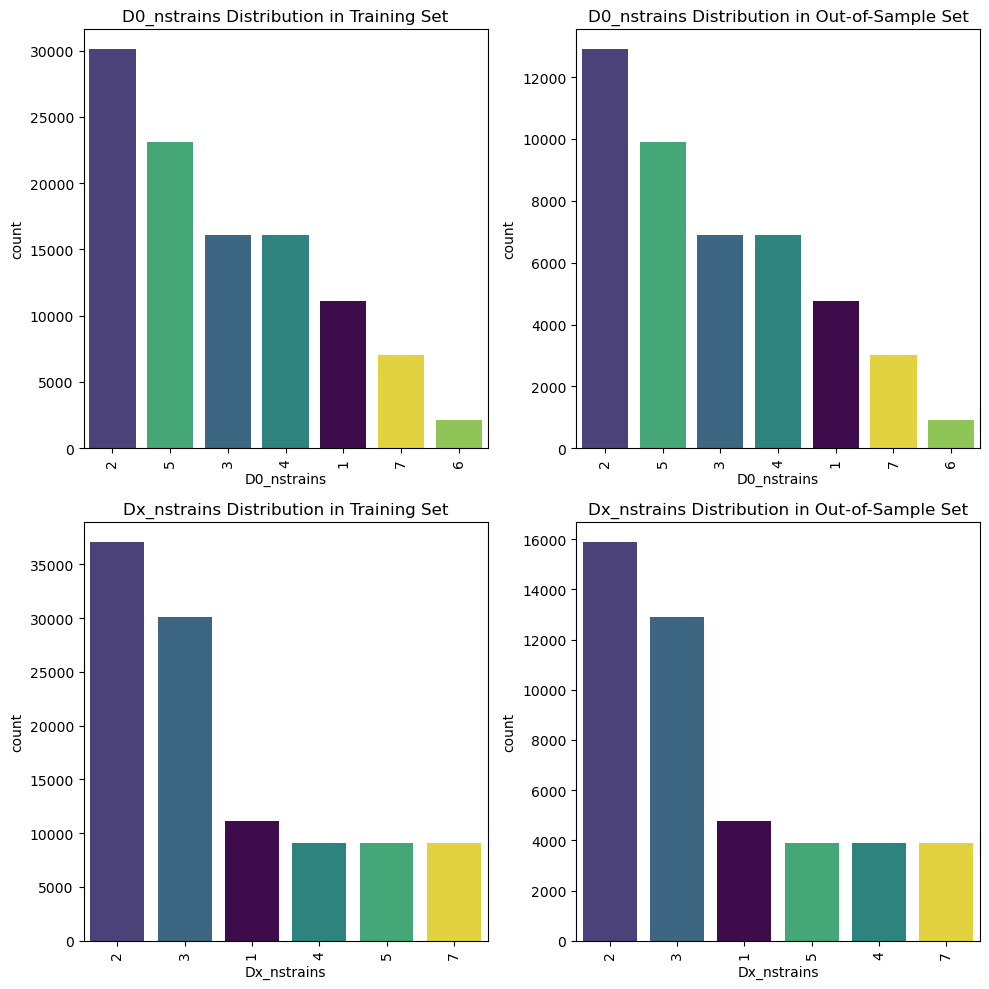

In [10]:
plt.figure(figsize=(10, 10))

# Subplot for D0_moi Distribution in Training Set
plt.subplot(2, 2, 1)
d0_moi_order_TT = df_TT['D0_nstrains'].value_counts().index  # Get order by count
sns.countplot(data=df_TT, x='D0_nstrains', order=d0_moi_order_TT, palette="viridis", hue='D0_nstrains', legend=False)
plt.xticks(rotation=90)
plt.title('D0_nstrains Distribution in Training Set')

# Subplot for D0_moi Distribution in Out-of-Sample Set
plt.subplot(2, 2, 2)
d0_moi_order_oos = df_oos['D0_nstrains'].value_counts().index  # Get order by count
sns.countplot(data=df_oos, x='D0_nstrains', order=d0_moi_order_oos, palette="viridis", hue='D0_nstrains', legend=False)
plt.xticks(rotation=90)
plt.title('D0_nstrains Distribution in Out-of-Sample Set')

# Subplot for Dx_moi Distribution in Training Set
plt.subplot(2, 2, 3)
dx_moi_order_TT = df_TT['Dx_nstrains'].value_counts().index  # Get order by count
sns.countplot(data=df_TT, x='Dx_nstrains', order=dx_moi_order_TT, palette="viridis", hue='Dx_nstrains', legend=False)
plt.xticks(rotation=90)
plt.title('Dx_nstrains Distribution in Training Set')

# Subplot for Dx_sample Distribution in Out-of-Sample Set
plt.subplot(2, 2, 4)
dx_moi_order_oos = df_oos['Dx_nstrains'].value_counts().index  # Get order by count
sns.countplot(data=df_oos, x='Dx_nstrains', order=dx_moi_order_oos, palette="viridis", hue='Dx_nstrains', legend=False)
plt.xticks(rotation=90)
plt.title('Dx_nstrains Distribution in Out-of-Sample Set')

plt.tight_layout() 
plt.show()


## Train test split (excluding oos data)

In [11]:
# Step 1: Count occurrences of each unique combination
stratify_columns = ['D0_nstrains', 'Dx_nstrains']
class_counts = df_TT[stratify_columns].value_counts()

# # Step 2: Identify classes with fewer than n instances
# insufficient_classes = class_counts[class_counts < 10].index

# # Step 3: Create a mask to filter out these insufficient classes
# mask = ~df_TT[stratify_columns].apply(tuple, axis=1).isin(insufficient_classes)

# # Step 4: Filter DataFrame
# df_TT_filtered = df_TT[mask]

# Step 5: Perform the train-test split on the filtered DataFrame
Xy_train, Xy_test  = train_test_split(df_TT, test_size=0.3, stratify=df_TT[stratify_columns], random_state=69)


In [12]:
exclude_cols = "D0_sample|Dx_sample|D0_nstrains|Dx_nstrains|NIDA1|NIDA2|shared_count|union_count|shared_prop|pair_type"

In [13]:
# If all is good with the split, separate features and labels for training and testing data. Exclude metadata!

X_train = Xy_train.drop(Xy_train.filter(regex=exclude_cols).columns.union(['labels']), axis=1)
X_test = Xy_test.drop(Xy_test.filter(regex=exclude_cols).columns.union(['labels']), axis=1)

# Retain the 'labels' column for y
y_train = Xy_train['labels']
y_test = Xy_test['labels']

In [14]:
# Calculate and print the percentage of each unique class: TT

print(f"Samples = ", len(y_train))

class_percentages = y_train.value_counts(normalize=True) * 100

for class_label, percentage in class_percentages.items():
    print(f"Class: {class_label}, Percentage: {percentage:.2f}%")

Samples =  73941
Class: 0, Percentage: 71.89%
Class: 1, Percentage: 28.11%


In [15]:
# Calculate and print the percentage of each unique class: TT

print(f"Samples = ", len(y_test))

class_percentages = y_test.value_counts(normalize=True) * 100

for class_label, percentage in class_percentages.items():
    print(f"Class: {class_label}, Percentage: {percentage:.2f}%")

Samples =  31689
Class: 0, Percentage: 71.41%
Class: 1, Percentage: 28.59%


## OOS X, y format

In [16]:
X_eval = df_oos.drop(df_oos.filter(regex=exclude_cols).columns.union(['labels']), axis=1)

y_eval = df_oos['labels']

# XGBoost model

In [17]:
def evaluate_model_metrics_cv(xgb_model, df, best_threshold, name):
    # Initialize lists to store the results for each fold
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    specificity_scores = []
    auc_scores = [] 
    conf_matrices = []

    # Separate features and labels
    X = df.drop(columns=['labels'])  # Assuming 'labels' is the target column
    y = df['labels']  # Target column

    # Initialize 10-fold Stratified Cross-Validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Iterate over each fold
    for train_index, test_index in skf.split(X, y):
        # Split the data into training and validation sets for the current fold
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Train the model on the current fold
        xgb_model.fit(X_train_fold, y_train_fold)

        # Get predicted probabilities for the positive class
        y_proba_fold = xgb_model.predict_proba(X_test_fold)[:, 1]

        # Apply the custom threshold to generate binary predictions
        y_pred_fold = np.where(y_proba_fold >= best_threshold, 1, 0)

        # Calculate the metrics for this fold
        accuracy = accuracy_score(y_test_fold, y_pred_fold)
        precision = precision_score(y_test_fold, y_pred_fold, average='binary')
        recall = recall_score(y_test_fold, y_pred_fold, average='binary')  # Sensitivity
        f1 = f1_score(y_test_fold, y_pred_fold, average='binary')

        # Confusion matrix
        conf_matrix = confusion_matrix(y_test_fold, y_pred_fold)
        tn, fp, fn, tp = conf_matrix.ravel()

        # Specificity: TN / (TN + FP)
        specificity = tn / (tn + fp)

        # AUC score
        auc = roc_auc_score(y_test_fold, y_proba_fold)

        # Append the metrics for this fold
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)  # Sensitivity
        specificity_scores.append(specificity)
        f1_scores.append(f1)
        auc_scores.append(auc)  # Append AUC score
        conf_matrices.append(conf_matrix)

    # Convert results to NumPy arrays for easier aggregation
    accuracy_scores = np.array(accuracy_scores)
    precision_scores = np.array(precision_scores)
    recall_scores = np.array(recall_scores)
    specificity_scores = np.array(specificity_scores)
    f1_scores = np.array(f1_scores)
    auc_scores = np.array(auc_scores)  # AUC scores

    # Create a DataFrame to store the aggregated metrics for the model
    metrics_df = pd.DataFrame({
        'Accuracy': [accuracy_scores.mean()],
        'Precision': [precision_scores.mean()],
        'Sensitivity (Recall)': [recall_scores.mean()],
        'Specificity': [specificity_scores.mean()],
        'F1-Score': [f1_scores.mean()],
        'AUC': [auc_scores.mean()],
        'Accuracy_sd': [accuracy_scores.std()],
        'Precision_sd': [precision_scores.std()],
        'Sensitivity_sd': [recall_scores.std()],
        'Specificity_sd': [specificity_scores.std()],
        'F1-Score_sd': [f1_scores.std()],
        'AUC_sd': [auc_scores.std()]
    }, index=[name])

    return metrics_df


In [18]:
def evaluate_oos(xgb_model, name):
 
    # Initialize lists to store the results
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    specificity_scores = []
    auc_scores = [] 
    conf_matrices = []

    # Step 1: Make predictions on the out-of-sample (OOS) dataset
    y_pred_xgb_eval = xgb_model.predict(X_eval)
    y_proba_xgb_eval = xgb_model.predict_proba(X_eval)[:, 1]  # Probabilities for class 1 (Recrudescent)

    # Step 3: Calculate the metrics
    accuracy = accuracy_score(y_eval, y_pred_xgb_eval)
    precision = precision_score(y_eval, y_pred_xgb_eval, average='binary')
    recall = recall_score(y_eval, y_pred_xgb_eval, average='binary')  # Sensitivity
    f1 = f1_score(y_eval, y_pred_xgb_eval, average='binary')

    # Step 4: Confusion matrix and specificity
    conf_matrix = confusion_matrix(y_eval, y_pred_xgb_eval)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)  # Specificity

    # Step 5: AUC score
    auc = roc_auc_score(y_eval, y_proba_xgb_eval)

    # Step 6: Append the metrics
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)  # Sensitivity
    specificity_scores.append(specificity)
    f1_scores.append(f1)
    auc_scores.append(auc)  # Append AUC score
    conf_matrices.append(conf_matrix)

    # Convert results to NumPy arrays for easier aggregation
    accuracy_scores = np.array(accuracy_scores)
    precision_scores = np.array(precision_scores)
    recall_scores = np.array(recall_scores)
    specificity_scores = np.array(specificity_scores)
    f1_scores = np.array(f1_scores)
    auc_scores = np.array(auc_scores)  # AUC scores

    # Step 7: Calculate Brier Score Loss
    #brier_score_eval = brier_score_loss(y_eval, y_proba_xgb_eval)

    # Step 8: Create a DataFrame to store the metrics for the model
    metrics_df = pd.DataFrame({
        'Accuracy': [accuracy_scores.mean()],
        'Precision': [precision_scores.mean()],
        'Sensitivity (Recall)': [recall_scores.mean()],
        'Specificity': [specificity_scores.mean()],
        'F1-Score': [f1_scores.mean()],
        'AUC': [auc_scores.mean()],
        'Accuracy_sd': [accuracy_scores.std()],
        'Precision_sd': [precision_scores.std()],
        'Sensitivity_sd': [recall_scores.std()],
        'Specificity_sd': [specificity_scores.std()],
        'F1-Score_sd': [f1_scores.std()],
        'AUC_sd': [auc_scores.std()]
    }, index=[name])

    return metrics_df, y_pred_xgb_eval, y_proba_xgb_eval # gonna need these too for fairness analysis


In [19]:
# Set up 10-fold Stratified K-Fold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=420)

### Base model

In [20]:
xgb_model_base = xgb.XGBClassifier(eval_metric = "error")

In [21]:
df_TT_filtered_no_metadata  = df_TT.drop(df_TT.filter(regex=exclude_cols), axis=1)

In [22]:
metrics_base_model = evaluate_model_metrics_cv(xgb_model_base, df_TT_filtered_no_metadata, best_threshold = 0.5, name = "base")
metrics_base_model

,Accuracy,Precision,Sensitivity (Recall),Specificity,F1-Score,AUC,Accuracy_sd,Precision_sd,Sensitivity_sd,Specificity_sd,F1-Score_sd,AUC_sd
base,0.986917,0.963627,0.99112,0.985261,0.977176,0.997295,0.00156,0.004429,0.001874,0.001848,0.00269,0.000332


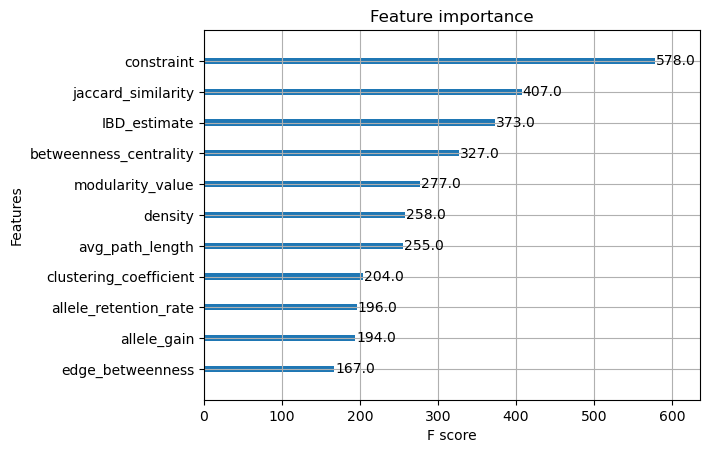

In [23]:
#feature importance

from xgboost import plot_importance
from matplotlib import pyplot

plot_importance(xgb_model_base)
pyplot.show()

## BAYESIAN HYPERPARAMETERS OPTIMIZATION

In [24]:
# Define the hyperparameter space
space = {
    'max_depth': hp.choice("max_depth", [2,3,4,5,6]), 
    'reg_alpha': hp.quniform('reg_alpha', 0, 200, 1), 
    'reg_lambda': hp.uniform('reg_lambda', 0, 1), 
    'colsample_bytree': hp.choice('colsample_bytree', [0.5, 0.6, 0.7, 0.8]),  
    'min_child_weight': hp.randint('min_child_weight', 20) + 1,  
    'gamma': hp.choice ('gamma', [0, 0.1, 0.2, 0.3, 0.4, 0.5]),
    'learning_rate': hp.choice('learning_rate', [0.01, 0.05, 0.1]), 
    'n_estimators': hp.choice('n_estimators', [100, 300, 500]),
    'seed': 420,
    #'scale_pos_weight': hp.choice('scale_pos_weight', [0.7, 0.8, 0.9, 1, 2, 3]), # for 50-50 datasets
    'scale_pos_weight': hp.choice('scale_pos_weight', [1, 2, 3, 4, 5, 6, 7]) #for datasets skewed towards NI
    #'scale_pos_weight': hp.choice('scale_pos_weight', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]) #for datasets skewed towards R
}

In [25]:
#function for tuning (balanced model)
def objective_balance(space):
    
    clf = xgb.XGBClassifier(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),  
        learning_rate=space['learning_rate'],  
        min_child_weight=int(space['min_child_weight']),  
        gamma=int(space['gamma']), 
        colsample_bytree=space['colsample_bytree'],  
        scale_pos_weight=float(space['scale_pos_weight']),
        reg_alpha=float(space['reg_alpha']),  
        reg_lambda=float(space['reg_lambda']),
        
    )
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, verbose=False)
    
    pred = clf.predict(X_test)

    # Step 3: Calculate the metrics
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='binary')
    recall = recall_score(y_test, pred, average='binary')  # Sensitivity
    f1 = f1_score(y_test, pred, average='binary')

    # Step 4: Confusion matrix and specificity
    conf_matrix = confusion_matrix(y_test, pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)  # Specificity

    # Step 5: AUC score
    auc = roc_auc_score(y_test, pred)

    # Append result to the DataFrame

    loss_ss = 1 - (recall + specificity)
    
    global tuning_results_df_balance
    tuning_results_df_balance = pd.concat([tuning_results_df_balance, pd.DataFrame({'Accuracy': [accuracy], 
                                                      'Precision': [precision], 
                                                      'Sensitivity (Recall)': [recall],
                                                      'Specificity': [specificity],
                                                      'f1-score': [f1],
                                                      'AUC': [auc],
                                                      'Hyperparams': [space],
                                                      'Loss':[loss_ss]})], ignore_index=True)
    
    return {'loss': loss_ss, 'status': STATUS_OK} 

In [26]:
# Running Hyperopt for balanced model

tuning_results_df_balance = pd.DataFrame()

trials = Trials()
best_hyperparams = fmin(fn=objective_balance,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials, 
                        rstate=np.random.default_rng(69),
                        verbose=1)

100%|██████| 100/100 [02:39<00:00,  1.60s/trial, best loss: -0.9786370887460332]


In [27]:
# CHECKPOINT
tuning_results_df_balance.to_csv(f"hyperparameter_tuning_results_df_balance_{data_name}.csv", index=False)

#rloead checkpoint df
tuning_results_df_balance = pd.read_csv(f'hyperparameter_tuning_results_df_balance_{data_name}.csv')

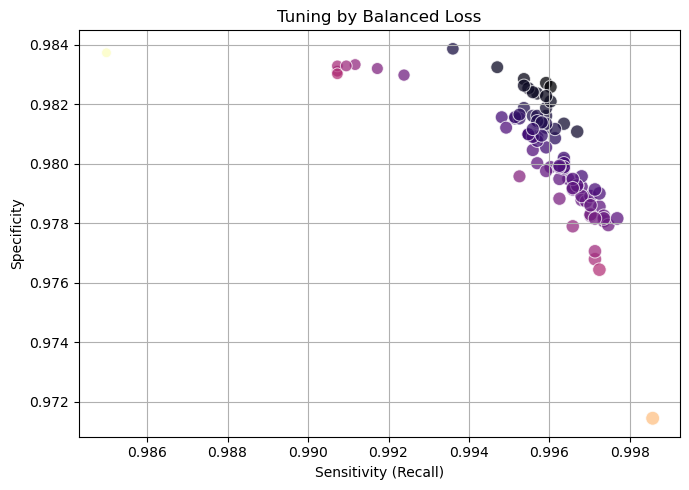

In [28]:
# Create a single figure
plt.figure(figsize=(7, 5))

# Scatter plot for tuning by balanced loss
sns.scatterplot(data=tuning_results_df_balance, 
                x='Sensitivity (Recall)', 
                y='Specificity',  
                size='Sensitivity (Recall)', 
                hue='Loss',
                sizes=(50, 100), 
                palette='magma', 
                alpha=0.75, 
                legend=False)

plt.title('Tuning by Balanced Loss')
plt.xlabel('Sensitivity (Recall)')
plt.ylabel('Specificity')
plt.grid(True)

plt.tight_layout()
plt.show()


In [29]:
#visually inspect similarly good models. go for lower values of n_estimators and learning_rate to pick the more generalizable model

# tuning_results_df_balance = tuning_results_df_balance.sort_values(
#     by=['Sensitivity (Recall)'], 
#     ascending=[False]
# )

tuning_results_df_balance = tuning_results_df_balance.sort_values(
    by=['Loss'], 
    ascending=[True]
)

pd.set_option('display.max_colwidth', None) 

tuning_results_df_balance.head(50)

,Accuracy,Precision,Sensitivity (Recall),Specificity,f1-score,AUC,Hyperparams,Loss
23,0.986494,0.958471,0.995917,0.982721,0.976835,0.989319,"{'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 11, 'n_estimators': 300, 'reg_alpha': 1.0, 'reg_lambda': 0.11156620233190977, 'scale_pos_weight': 3, 'seed': 420}",-0.978637
90,0.986431,0.958170,0.996027,0.982588,0.976732,0.989307,"{'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 500, 'reg_alpha': 3.0, 'reg_lambda': 0.5492209872296421, 'scale_pos_weight': 4, 'seed': 420}",-0.978615
24,0.986431,0.958754,0.995365,0.982853,0.976716,0.989109,"{'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'reg_alpha': 2.0, 'reg_lambda': 0.08806945721110693, 'scale_pos_weight': 3, 'seed': 420}",-0.978218
92,0.986178,0.957454,0.995917,0.982279,0.976306,0.989098,"{'colsample_bytree': 0.7, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 500, 'reg_alpha': 5.0, 'reg_lambda': 0.7430651700013878, 'scale_pos_weight': 4, 'seed': 420}",-0.978195
75,0.986083,0.957052,0.996027,0.982102,0.976151,0.989064,"{'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 12.0, 'reg_lambda': 0.3526595422738387, 'scale_pos_weight': 3, 'seed': 420}",-0.978129
20,0.986178,0.957648,0.995696,0.982367,0.976301,0.989031,"{'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 11, 'n_estimators': 300, 'reg_alpha': 5.0, 'reg_lambda': 0.42069661721475604, 'scale_pos_weight': 3, 'seed': 420}",-0.978063
27,0.986241,0.958046,0.995475,0.982544,0.976402,0.989009,"{'colsample_bytree': 0.5, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 14, 'n_estimators': 300, 'reg_alpha': 0.0, 'reg_lambda': 0.23079730325725759, 'scale_pos_weight': 3, 'seed': 420}",-0.978019
68,0.986273,0.958245,0.995365,0.982632,0.976452,0.988998,"{'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'reg_alpha': 5.0, 'reg_lambda': 0.2024657351907389, 'scale_pos_weight': 3, 'seed': 420}",-0.977997
65,0.986178,0.957745,0.995585,0.982411,0.976299,0.988998,"{'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 11, 'n_estimators': 300, 'reg_alpha': 7.0, 'reg_lambda': 0.7059446298632608, 'scale_pos_weight': 3, 'seed': 420}",-0.977997
74,0.986525,0.959647,0.994703,0.983251,0.976860,0.988977,"{'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'reg_alpha': 1.0, 'reg_lambda': 0.5849146160450617, 'scale_pos_weight': 2, 'seed': 420}",-0.977953


In [30]:
## choose a good model

import ast

selected_model_index = 21

#best_hyperparams_final = tuning_results_df_balance.loc[selected_model_index, 'Hyperparams']

# Assuming best_hyperparams_final is a string representation of a dictionary
best_hyperparams_final = ast.literal_eval(tuning_results_df_balance.loc[selected_model_index, 'Hyperparams'])

print("Best Hyperparameters:\n\n", best_hyperparams_final)

Best Hyperparameters:

 {'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 11, 'n_estimators': 100, 'reg_alpha': 0.0, 'reg_lambda': 0.16398943986675085, 'scale_pos_weight': 3, 'seed': 420}


In [31]:
# Specify the file path where you want to save the hyperparameters
file_path = f'best_hyperparams_{data_name}.txt'

# Open the file in write mode and write the hyperparameters
with open(file_path, 'w') as f:
    for key, value in best_hyperparams_final.items():
        f.write(f'{key}: {value}\n')

In [32]:
# Use the values directly from best_hyperparams
xgb_model_hyperopt = xgb.XGBClassifier(

    eval_metric = "error",
    #optimized params44
    n_estimators=best_hyperparams_final['n_estimators'], 
    random_state=best_hyperparams_final['seed'],  
    scale_pos_weight=best_hyperparams_final['scale_pos_weight'],
    colsample_bytree=best_hyperparams_final['colsample_bytree'],
    learning_rate=best_hyperparams_final['learning_rate'],
    max_depth=best_hyperparams_final['max_depth'],
    min_child_weight=best_hyperparams_final['min_child_weight'],
    gamma=best_hyperparams_final['gamma'],
    reg_alpha=best_hyperparams_final['reg_alpha'],
    reg_lambda=best_hyperparams_final['reg_lambda']

)

In [33]:
# import joblib

# model_path = 'CONTROLS_pairs_db__shared_by_0.75_60_amps__MAF_0.01_FINAL_FEATURES_METADATA_subsampled__CLEAN_FEATS_FINAL_xgb_model_hyperopt__xgb_model_hyperopt.joblib'
# xgb_model_hyperopt = joblib.load(model_path)

In [34]:
# xgb_model_hyperopt

In [35]:
#does the tuned model behave similarly with all the training data cv= 10? if significantly worse, probably overfit

metrics_hyperopt = evaluate_model_metrics_cv(xgb_model_hyperopt, df_TT_filtered_no_metadata, best_threshold = 0.5, name =  "hyperopt")
metrics_hyperopt

,Accuracy,Precision,Sensitivity (Recall),Specificity,F1-Score,AUC,Accuracy_sd,Precision_sd,Sensitivity_sd,Specificity_sd,F1-Score_sd,AUC_sd
hyperopt,0.985629,0.955567,0.995443,0.981765,0.975092,0.996478,0.001367,0.004371,0.00147,0.001867,0.002325,0.000498


### MODEL VALIDATION

In [36]:
# Separate features and labels FOR VALIDATION

X_TT = df_TT_filtered_no_metadata.drop(columns=['labels'])  # Assuming 'labels' is the target column
y_TT = df_TT_filtered_no_metadata['labels']  # Target column

In [37]:
xgb_model_hyperopt

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=11, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=420, ...)

In [38]:
# EVALUATION AGAINST OOS DATASET
xgb_model_hyperopt.fit(X_TT, y_TT)  # FIT TO ALL TT DATA
metrics_hyperopt_oos, y_pred_hyperopt, y_proba_hyperopt = evaluate_oos(xgb_model_hyperopt, "hyperopt_oos")

In [39]:
# confirm that all is ok. results must be the same as in the best learning_Rate + n_estimators above

metrics_hyperopt_oos, y_pred_hyperopt, y_proba_hyperopt = evaluate_oos(xgb_model_hyperopt, "hyperopt_oos") #y_pred, y_proba for fariness assessment
metrics_hyperopt_oos

,Accuracy,Precision,Sensitivity (Recall),Specificity,F1-Score,AUC,Accuracy_sd,Precision_sd,Sensitivity_sd,Specificity_sd,F1-Score_sd,AUC_sd
hyperopt_oos,0.985355,0.954556,0.995457,0.981387,0.974577,0.996451,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
#metrics_hyperopt_oos.to_csv(f'model_stats_on_validation_data_{data_name}.csv', index = False)

### probability threshold

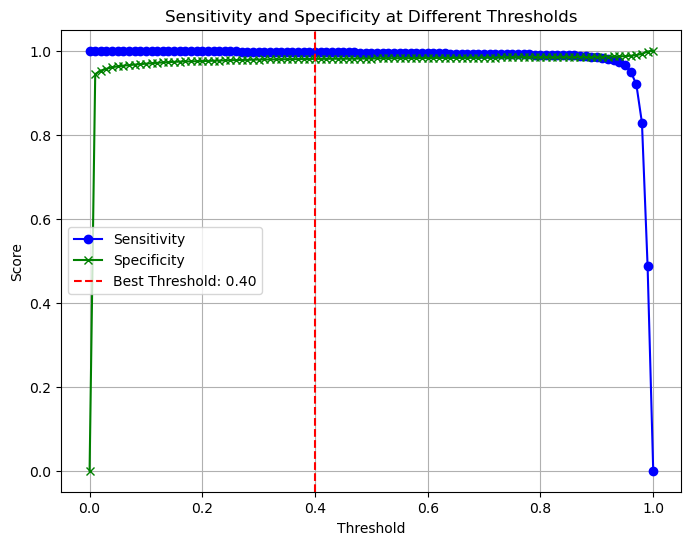

Best Threshold: 0.40
Sensitivity at Best Threshold: 0.9968
Specificity at Best Threshold: 0.9805


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to calculate sensitivity and specificity
def calculate_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

# Initialize lists for storing results
sensitivities = []
specificities = []
youden_j = []
thresholds = np.arange(0.0, 1.01, 0.01)

# Loop through thresholds to calculate sensitivity, specificity, and Youden's J statistic
for threshold in thresholds:
    y_pred_threshold = (y_proba_hyperopt >= threshold).astype(int)  # Binarize predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_eval, y_pred_threshold).ravel()
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # Youden's J statistic = Sensitivity + Specificity - 1
    youden_j.append(sensitivity + specificity - 1)

# Find the threshold with the maximum Youden's J
best_threshold_index = np.argmax(youden_j)
best_threshold = thresholds[best_threshold_index]

# Plot Sensitivity vs Specificity
plt.figure(figsize=(8, 6))
plt.plot(thresholds, sensitivities, label='Sensitivity', marker='o', color='b')
plt.plot(thresholds, specificities, label='Specificity', marker='x', color='g')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.title('Sensitivity and Specificity at Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Print best threshold and corresponding sensitivity, specificity
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Sensitivity at Best Threshold: {sensitivities[best_threshold_index]:.4f}")
print(f"Specificity at Best Threshold: {specificities[best_threshold_index]:.4f}")


In [42]:
sens_spec = pd.DataFrame({
    'Sensitivity (Recall)': sensitivities,
    'Specificity': specificities
})

# Add a new column 'threshold' filled with values from 0.0 to 1.0 (inclusive) with a step of 0.01
sens_spec['threshold'] = np.arange(0.0, 1.01, 0.01)

In [43]:

def best_balanced_threshold(y_proba_hyperopt, y_eval):
    # Initialize lists for storing results
    sensitivities = []
    specificities = []
    equality = []
    thresholds = np.arange(0.0, 1.01, 0.01)

    # Loop through thresholds to calculate sensitivity, specificity, and Youden's J statistic
    for threshold in thresholds:
        y_pred_threshold = (y_proba_hyperopt >= threshold).astype(int)  # Binarize predictions based on threshold
        tn, fp, fn, tp = confusion_matrix(y_eval, y_pred_threshold).ravel()
        
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Avoid division by zero
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Avoid division by zero
        
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        
        # Youden's J statistic = Sensitivity + Specificity - 1
        equality.append(0.5/(sensitivity - specificity))

    # Find the threshold with the most equal spec and sens
    best_threshold_index = np.argmax(equality)
    best_threshold = thresholds[best_threshold_index]

    best_sensitivity = sensitivities[best_threshold_index]
    best_specificity = specificities[best_threshold_index]

    # Plot Sensitivity vs Specificity
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, sensitivities, label='Sensitivity', marker='o', color='b')
    plt.plot(thresholds, specificities, label='Specificity', marker='x', color='g')
    plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
    plt.title('Sensitivity and Specificity at Different Thresholds')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print best threshold and corresponding sensitivity, specificity
    print(f"Best Threshold: {best_threshold:.2f}")
    print(f"Sensitivity at Best Threshold: {best_sensitivity:.4f}")
    print(f"Specificity at Best Threshold: {best_specificity:.4f}")
    return best_threshold


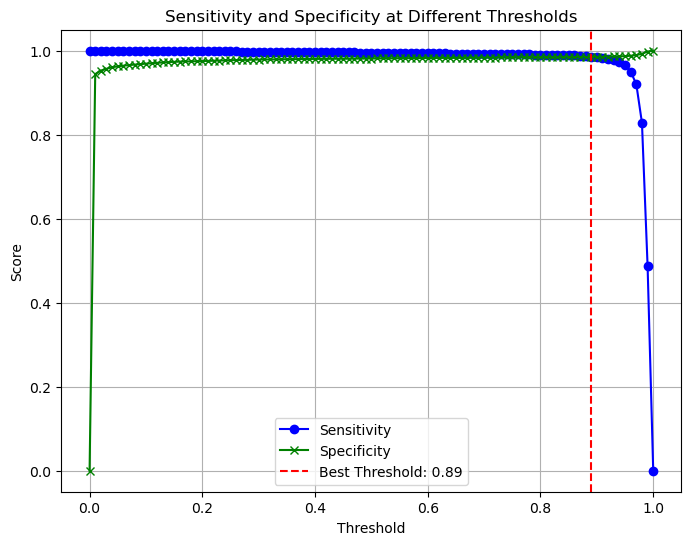

Best Threshold: 0.89
Sensitivity at Best Threshold: 0.9862
Specificity at Best Threshold: 0.9851


In [44]:
best_threshold = best_balanced_threshold(y_proba_hyperopt, y_eval)

In [45]:
best_threshold

0.89

In [46]:
stats_validation_with_best_threshold = sens_spec[sens_spec['threshold'] == best_threshold]

stats_validation_with_best_threshold.to_csv(f'stats_validation_with_best_threshold_{data_name}.csv', index = False)

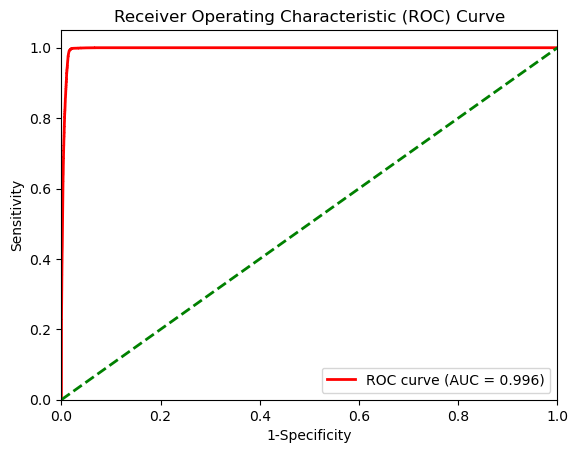

In [47]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_eval, y_proba_hyperopt)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')  # Dashed diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Model fairness assessment

In [48]:

df_oos_subset = df_oos[['labels', 'D0_sample', 'Dx_sample',  'D0_nstrains', 'Dx_nstrains']].reset_index(drop=True)

y_pred_hyperopt_df = pd.DataFrame(y_pred_hyperopt, columns=['predictions'])

y_proba_hyperopt_df = pd.DataFrame(y_proba_hyperopt, columns=['probabilities'])


# Apply the best_threshold to convert probabilities into predictions: predictions are set to 1 if the probability is >= best_threshold, otherwise 0
probabilities = y_proba_hyperopt_df['probabilities']
y_pred_hyperopt_df['predictions'] = np.where(probabilities >= best_threshold, 1, 0)


# Resetting the index for concatenation
df_oos_subset.reset_index(drop=True, inplace=True)

# Concatenate along axis 1 (columns)
oos_fairness_hyperopt = pd.concat([y_pred_hyperopt_df, y_proba_hyperopt_df, df_oos_subset], axis=1)


In [49]:
oos_fairness_hyperopt

,predictions,probabilities,labels,D0_sample,Dx_sample,D0_nstrains,Dx_nstrains
0,0,0.000087,0,1952511.2__TES22_NextSeq01_1972502.4__TES22_NextSeq01,1970710.5__TES22_NextSeq01_1972046.3__TES22_NextSeq01_1972288.7__TES22_NextSeq01_1972346.4__TES22_NextSeq01_1973250.3__TES22_NextSeq01,2,5
1,1,0.994771,1,1952511.2__TES22_NextSeq01_1966824.6__TES22_NextSeq01_1972046.3__TES22_NextSeq01_1972185.9__TES22_NextSeq01_2005707.7__TES22_NextSeq01,1965739.4__TES22_NextSeq01_1966824.6__TES22_NextSeq01_1973131.5__TES22_NextSeq01_1973798.0__TES22_NextSeq01,5,4
2,0,0.001819,0,1966850.5__TES22_NextSeq01_1970505.7__TES22_NextSeq01_1970710.5__TES22_NextSeq01_1973131.5__TES22_NextSeq01_1976547.3__TES22_NextSeq01,1972269.6__TES22_NextSeq01_1973320.3__TES22_NextSeq01,5,2
3,0,0.000300,0,1965714.1__TES22_NextSeq01_1996352.5__TES22_NextSeq01,1966850.5__TES22_NextSeq01_1972046.3__TES22_NextSeq01_1973131.5__TES22_NextSeq01_1973250.3__TES22_NextSeq01_1973320.3__TES22_NextSeq01_1973798.0__TES22_NextSeq01_1976547.3__TES22_NextSeq01,2,7
4,1,0.994131,1,1972074.6__TES22_NextSeq01_1973131.5__TES22_NextSeq01,1966863.5__TES22_NextSeq01_1973131.5__TES22_NextSeq01_1973798.0__TES22_NextSeq01,2,3
...,...,...,...,...,...,...,...
45265,1,0.988012,1,1952511.2__TES22_NextSeq01_1970710.5__TES22_NextSeq01_1972185.9__TES22_NextSeq01_1973250.3__TES22_NextSeq01,1952511.2__TES22_NextSeq01_1976547.3__TES22_NextSeq01,4,2
45266,1,0.991396,1,1965714.1__TES22_NextSeq01_1972269.6__TES22_NextSeq01_1972288.7__TES22_NextSeq01_1976547.3__TES22_NextSeq01,1972269.6__TES22_NextSeq01_1973320.3__TES22_NextSeq01,4,2
45267,0,0.001057,0,1972502.4__TES22_NextSeq01_1976547.3__TES22_NextSeq01,1952511.2__TES22_NextSeq01_1966824.6__TES22_NextSeq01_1970710.5__TES22_NextSeq01_1972288.7__TES22_NextSeq01_1972346.4__TES22_NextSeq01_1973131.5__TES22_NextSeq01_1973798.0__TES22_NextSeq01,2,7
45268,0,0.000061,0,1965777.8__TES22_NextSeq01_1972257.3__TES22_NextSeq01_1972346.4__TES22_NextSeq01_1972502.4__TES22_NextSeq01,1967551.0__TES22_NextSeq01_1972331.0__TES22_NextSeq01,4,2


In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def process_fairness(oos_fairness_hyperopt, D0_column, Dx_column, best_threshold, data_name):

    results = []

    # Apply the best_threshold to convert probabilities into predictions
    probabilities = oos_fairness_hyperopt['probabilities']
    oos_fairness_hyperopt['predictions'] = np.where(probabilities >= best_threshold, 1, 0)

    # Group by the specified columns (D0_column and Dx_column)
    grouped = oos_fairness_hyperopt.groupby([D0_column, Dx_column])

    # Calculate metrics for each group
    for (d0_moi, dx_moi), group in grouped:
        y_true = group['labels'].dropna()
        y_pred = group['predictions'].dropna()

        # Calculate proportions of 'NI' and 'R'
        count_NI = (group['labels'] == 0).sum()
        count_R = (group['labels'] == 1).sum()
        total = count_NI + count_R
        median_pred_score = group['probabilities'].median()

        proportion_NI = count_NI / total if total > 0 else 0
        proportion_R = count_R / total if total > 0 else 0

        # Make sure to align the true labels and predictions
        if y_true.index.equals(y_pred.index):
            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, zero_division=0)

            # Only calculate recall if there are positive samples (R)
            if count_R > 0:
                recall = recall_score(y_true, y_pred, zero_division=0)
                f1 = f1_score(y_true, y_pred, zero_division=0)
            else:
                recall = None  # Skip recall when no positive samples
                f1 = None      # Skip F1 score when no positive samples

            # Calculate specificity from the confusion matrix
            conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])

            # Ensure that the confusion matrix has the correct dimensions (2x2)
            if conf_matrix.size == 4:
                tn, fp, fn, tp = conf_matrix.ravel()
            elif conf_matrix.size == 1:
                # Handle the case where only one class is present
                if (y_true == 0).all():
                    tn, fp, fn, tp = conf_matrix[0][0], 0, 0, 0
                else:
                    tn, fp, fn, tp = 0, 0, 0, conf_matrix[0][0]
            else:
                tn, fp, fn, tp = 0, 0, 0, 0  # Fallback case if somehow confusion matrix size is unexpected

            # Avoid division by zero for specificity
            specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

            # Append the results
            results.append({
                D0_column: d0_moi,
                Dx_column: dx_moi,
                'count_NI': count_NI,
                'count_R': count_R,
                'Proportion_NI': proportion_NI,
                'Proportion_R': proportion_R,
                'Accuracy': accuracy,
                'Precision': precision,
                'Sensitivity (Recall)': recall,
                'Specificity': specificity,
                'F1_Score': f1
                #'median_pred_score': median_pred_score
            })

    # Create a DataFrame from the results
    metrics_df_moi_hyperopt = pd.DataFrame(results)

    ## Create a new column combining D0 and Dx
    #metrics_df_moi_hyperopt['D0_Dx_combined'] = metrics_df_moi_hyperopt[D0_column].astype(str) + ' / ' + metrics_df_moi_hyperopt[Dx_column].astype(str)


    # Melt the DataFrame to a long format suitable for seaborn
    metrics_melted_moi = metrics_df_moi_hyperopt.melt(id_vars=[D0_column, Dx_column], 
                                     value_vars=['Sensitivity (Recall)', 'Specificity'], 
                                     var_name='Metric', value_name='Value')

    # List of metrics to create heatmaps for
    metrics = ['Sensitivity (Recall)', 'Specificity']

    # Set up the subplot grid
    nrows = 1
    ncols = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11, 5))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    # Create heatmaps for each metric
    for i, metric in enumerate(metrics):
        # Create a pivot table for the current metric
        pivot_table = metrics_melted_moi[metrics_melted_moi['Metric'] == metric].pivot_table(
            index=D0_column,
            columns=Dx_column,
            values='Value',
            fill_value=None  # Fill missing values with None
        )

        # Create the heatmap on the corresponding subplot
        sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis", cbar=True, ax=axes[i], vmin=0, vmax=1)

        # Customize the plot
        axes[i].set_title(f'{metric}')
        axes[i].set_xlabel(Dx_column)
        axes[i].set_ylabel(D0_column)
        axes[i].tick_params(axis='x', rotation=45)  # Rotate x-ticks for better readability

    # Adjust layout
    plt.tight_layout()

    # Save the figure
    plt.savefig(f'fairness_{data_name}.png', dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()

    return metrics_df_moi_hyperopt


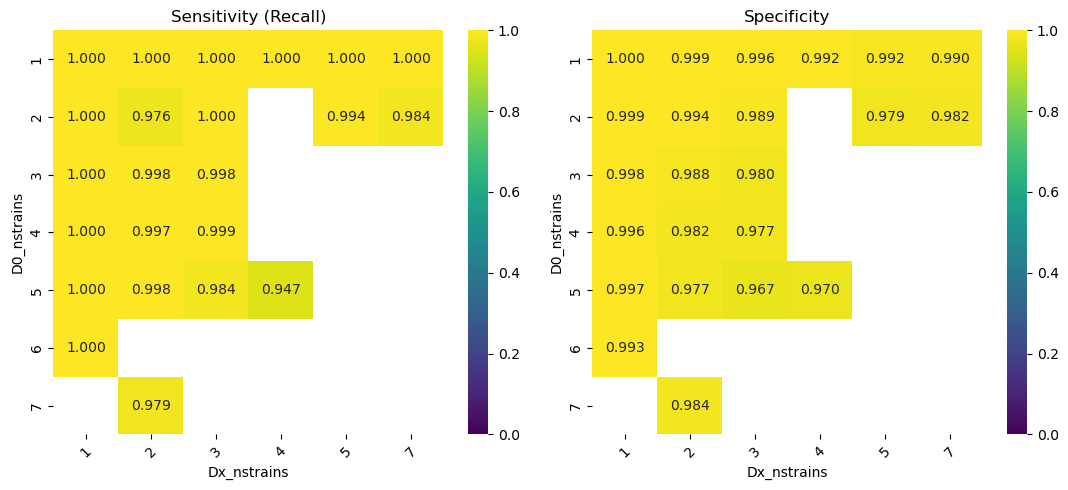

In [51]:
metrics_df_nstrains = process_fairness(oos_fairness_hyperopt, 'D0_nstrains', 'Dx_nstrains', best_threshold=best_threshold, data_name = data_name)

In [52]:
metrics_df_nstrains.to_csv(f'fairness_{data_name}.csv', index=False)
metrics_df_nstrains

,D0_nstrains,Dx_nstrains,count_NI,count_R,Proportion_NI,Proportion_R,Accuracy,Precision,Sensitivity (Recall),Specificity,F1_Score
0,1,1,262,8,0.970370,0.029630,1.000000,1.000000,1.000000,1.000000,1.000000
1,1,2,847,53,0.941111,0.058889,0.998889,0.981481,1.000000,0.998819,0.990654
2,1,3,804,96,0.893333,0.106667,0.996667,0.969697,1.000000,0.996269,0.984615
3,1,4,777,123,0.863333,0.136667,0.993333,0.953488,1.000000,0.992278,0.976190
4,1,5,747,153,0.830000,0.170000,0.993333,0.962264,1.000000,0.991968,0.980769
5,1,7,677,223,0.752222,0.247778,0.992222,0.969565,1.000000,0.989660,0.984547
6,2,1,826,74,0.917778,0.082222,0.998889,0.986667,1.000000,0.998789,0.993289
7,2,2,2576,424,0.858667,0.141333,0.991333,0.962791,0.976415,0.993789,0.969555
8,2,3,2397,603,0.799000,0.201000,0.991000,0.957143,1.000000,0.988736,0.978102
9,2,5,2109,891,0.703000,0.297000,0.983667,0.952688,0.994388,0.979137,0.973092


# REFIT MODEL WITH ALL TT + 00S DATA

In [53]:
# Calculate and print the percentage of each unique class: TT
class_percentages = df["labels"].value_counts(normalize=True) * 100

for class_label, percentage in class_percentages.items():
    print(f"Class: {class_label}, Percentage: {percentage:.2f}%")

Class: 0, Percentage: 71.76%
Class: 1, Percentage: 28.24%


In [54]:
df_filtered_no_metadata = df.drop(df.filter(regex=exclude_cols), axis=1)

In [55]:
df_filtered_no_metadata

,jaccard_similarity,allele_retention_rate,allele_gain,density,clustering_coefficient,avg_path_length,betweenness_centrality,modularity_value,edge_betweenness,constraint,IBD_estimate,labels
PairsID,,,,,,,,,,,,
1,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000,-8.565197e-18,1.000000,0.079975,1.000,1
2,0.123596,0.220000,0.438202,0.611593,0.950891,1.402451,0.004624,3.006980e-01,2.292820,0.070052,0.000,0
3,0.149425,0.260000,0.425287,0.634055,0.944032,1.386795,0.004547,2.698735e-01,2.186745,0.068990,0.000,0
4,0.149425,0.260000,0.425287,0.634055,0.944032,1.386795,0.004547,2.698735e-01,2.186745,0.068990,0.000,0
5,0.176471,0.300000,0.411765,0.656863,0.937987,1.372549,0.004484,2.407143e-01,2.088922,0.068141,0.040,0
...,...,...,...,...,...,...,...,...,...,...,...,...
150896,0.318182,0.823529,0.613636,0.915940,0.973008,1.184309,0.000842,1.061581e-01,1.292273,0.020212,0.794,1
150897,0.347032,0.844444,0.589041,0.924343,0.973503,1.195048,0.000895,1.049211e-01,1.291965,0.020150,0.796,1
150898,0.362385,0.858696,0.577982,0.930749,0.974672,1.199510,0.000919,1.030696e-01,1.287758,0.020132,0.984,1


In [56]:
#whole cv evaluation just to be on the safe side

evaluate_model_metrics_cv(xgb_model_hyperopt, df_filtered_no_metadata, best_threshold = best_threshold, name = "FINAL")

,Accuracy,Precision,Sensitivity (Recall),Specificity,F1-Score,AUC,Accuracy_sd,Precision_sd,Sensitivity_sd,Specificity_sd,F1-Score_sd,AUC_sd
FINAL,0.985838,0.963705,0.987022,0.985373,0.975223,0.996593,0.001003,0.001966,0.002135,0.000806,0.001756,0.000174


In [57]:
# Separate features and labels

X_all = df_filtered_no_metadata.drop(columns=['labels'])  # Assuming 'labels' is the target column
y_all = df_filtered_no_metadata['labels']  # Target column

In [58]:
# fit all TT + OOS data into the model: THIS IS THE FINAL MODEL

xgb_model_hyperopt.fit(X_all, y_all)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=11, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=420, ...)

# Save model

In [59]:
import pickle

# Save the model to a pickle file
with open(f'XGB_MODEL_{data_name}.pkl', 'wb') as file:
    pickle.dump(xgb_model_hyperopt, file)

# OR

import joblib

# Save the model to a file
joblib.dump(xgb_model_hyperopt, f'XGB_MODEL_{data_name}.joblib')

['XGB_MODEL_top_50_amps_30_clones.joblib']